In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews", with_info = True, as_supervised = True)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete47HJA5/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete47HJA5/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete47HJA5/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [3]:
import numpy as np

train_data = imdb['train']
test_data = imdb['test']

training_sentences = []
training_labels = []
testing_sentences = []
testing_labels = []

for x,y in train_data:
    training_sentences.append(str(x.numpy()))
    training_labels.append(y.numpy())
    
for x,y in test_data:
    testing_sentences.append(str(x.numpy()))
    testing_labels.append(y.numpy())

training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

In [4]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

vocab_size = 10000
max_length = 120
oov_word = "<OOV>"
trunc_type = 'post'
embedding_dim = 16

In [5]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_word)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(sequences, maxlen = max_length, truncating = trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen = max_length, truncating = trunc_type)
testing_padded.shape

(25000, 120)

In [6]:
import tensorflow as tf
from tensorflow.keras import layers

model = tf.keras.Sequential([
    layers.Embedding(vocab_size, 64),
    layers.Bidirectional(layers.LSTM(64 , return_sequences = True)),
    layers.Bidirectional(layers.LSTM(32)),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(1, activation = 'sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          640000    
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        66048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 751,489
Trainable params: 751,489
Non-trai

In [7]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
history = model.fit(training_padded, training_labels, epochs = 10, validation_data = (testing_padded, testing_labels))

Epoch 1/10
782/782 [==============================] - 89s 93ms/step - loss: 0.4505 - accuracy: 0.7837 - val_loss: 0.3892 - val_accuracy: 0.8244
Epoch 2/10
782/782 [==============================] - 34s 43ms/step - loss: 0.2845 - accuracy: 0.8834 - val_loss: 0.4157 - val_accuracy: 0.8211
Epoch 3/10
782/782 [==============================] - 33s 42ms/step - loss: 0.1972 - accuracy: 0.9243 - val_loss: 0.4716 - val_accuracy: 0.8028
Epoch 4/10
782/782 [==============================] - 31s 40ms/step - loss: 0.1253 - accuracy: 0.9538 - val_loss: 0.6232 - val_accuracy: 0.8076
Epoch 5/10
782/782 [==============================] - 26s 34ms/step - loss: 0.0814 - accuracy: 0.9722 - val_loss: 0.6242 - val_accuracy: 0.7910
Epoch 6/10
782/782 [==============================] - 28s 35ms/step - loss: 0.0489 - accuracy: 0.9826 - val_loss: 0.8188 - val_accuracy: 0.7932
Epoch 7/10
782/782 [==============================] - 30s 39ms/step - loss: 0.0419 - accuracy: 0.9858 - val_loss: 0.8945 - val_accuracy:

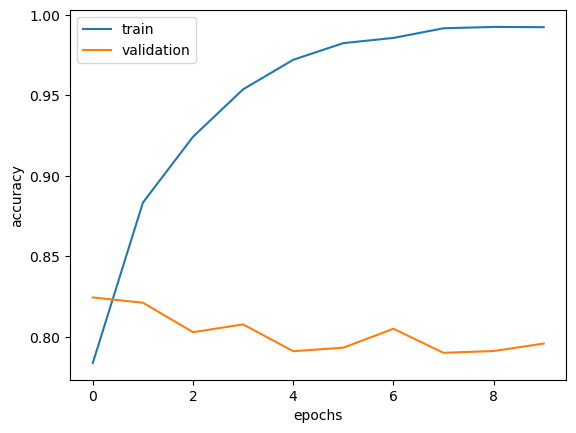

In [8]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train','validation'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

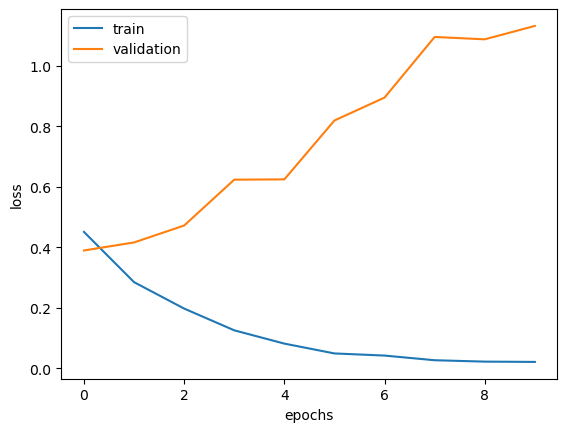

In [9]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [10]:
imdb, info = tfds.load("imdb_reviews/subwords8k", with_info = True, as_supervised = True)
train_data_8k, test_data_8k = imdb['train'], imdb['test']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteRFU58Q/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteRFU58Q/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteRFU58Q/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [11]:
tokenizer = info.features['text'].encoder
print(tokenizer.subwords)

['the_', ', ', '. ', 'a_', 'and_', 'of_', 'to_', 's_', 'is_', 'br', 'in_', 'I_', 'that_', 'this_', 'it_', ' /><', ' />', 'was_', 'The_', 'as_', 't_', 'with_', 'for_', '.<', 'on_', 'but_', 'movie_', ' (', 'are_', 'his_', 'have_', 'film_', 'not_', 'ing_', 'be_', 'ed_', 'you_', ' "', 'it', 'd_', 'an_', 'he_', 'by_', 'at_', 'one_', 'who_', 'y_', 'from_', 'e_', 'or_', 'all_', 'like_', 'they_', '" ', 'so_', 'just_', 'has_', ') ', 'her_', 'about_', 'out_', 'This_', 'some_', 'ly_', 'movie', 'film', 'very_', 'more_', 'It_', 'would_', 'what_', 'when_', 'which_', 'good_', 'if_', 'up_', 'only_', 'even_', 'their_', 'had_', 'really_', 'my_', 'can_', 'no_', 'were_', 'see_', 'she_', '? ', 'than_', '! ', 'there_', 'get_', 'been_', 'into_', ' - ', 'will_', 'much_', 'story_', 'because_', 'ing', 'time_', 'n_', 'we_', 'ed', 'me_', ': ', 'most_', 'other_', 'don', 'do_', 'm_', 'es_', 'how_', 'also_', 'make_', 'its_', 'could_', 'first_', 'any_', "' ", 'people_', 'great_', 've_', 'ly', 'er_', 'made_', 'r_', 'B

In [12]:


training_sentences_8k = []
training_labels_8k = []
testing_sentences_8k = []
testing_labels_8k = []

for x, y in train_data_8k:
    training_sentences_8k.append(list(x.numpy()))
    training_labels_8k.append((int)(y.numpy()))

for x, y in test_data_8k:
    testing_sentences_8k.append(list(x.numpy()))
    testing_labels_8k.append((int)(y.numpy()))
 
max_length = 500
training_sentences_8k = pad_sequences(training_sentences_8k, maxlen= max_length)
testing_sentences_8k = pad_sequences(testing_sentences_8k, maxlen= max_length)

training_labels_8k = np.array(training_labels_8k)
testing_labels_8k = np.array(testing_labels_8k)
    

In [13]:
model = tf.keras.Sequential([
    layers.Embedding(tokenizer.vocab_size, 64),
    layers.Bidirectional(layers.LSTM(64 , return_sequences = True)),
    layers.Bidirectional(layers.LSTM(32)),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(1, activation = 'sigmoid')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          523840    
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 128)        66048     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 635,329
Trainable params: 635,329
Non-tr

In [14]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
history8k = model.fit(training_sentences_8k,training_labels_8k, epochs = 10, validation_data = (testing_sentences_8k, testing_labels_8k))

Epoch 1/10
782/782 [==============================] - 220s 271ms/step - loss: 0.4741 - accuracy: 0.7711 - val_loss: 0.3889 - val_accuracy: 0.8354
Epoch 2/10
782/782 [==============================] - 133s 170ms/step - loss: 0.3100 - accuracy: 0.8735 - val_loss: 0.4138 - val_accuracy: 0.8159
Epoch 3/10
782/782 [==============================] - 117s 150ms/step - loss: 0.2384 - accuracy: 0.9079 - val_loss: 0.3907 - val_accuracy: 0.8589
Epoch 4/10
782/782 [==============================] - 103s 132ms/step - loss: 0.1730 - accuracy: 0.9358 - val_loss: 0.4227 - val_accuracy: 0.8422
Epoch 5/10
782/782 [==============================] - 98s 125ms/step - loss: 0.1254 - accuracy: 0.9561 - val_loss: 0.4442 - val_accuracy: 0.8460
Epoch 6/10
782/782 [==============================] - 96s 123ms/step - loss: 0.1083 - accuracy: 0.9632 - val_loss: 0.5132 - val_accuracy: 0.8506
Epoch 7/10
782/782 [==============================] - 95s 122ms/step - loss: 0.1097 - accuracy: 0.9613 - val_loss: 0.5622 - va

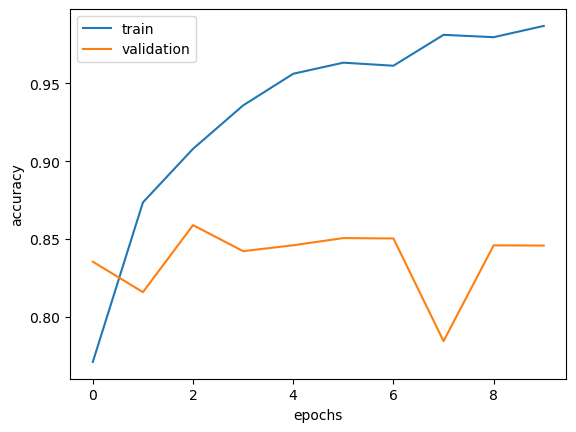

In [15]:
plt.plot(history8k.history['accuracy'])
plt.plot(history8k.history['val_accuracy'])
plt.legend(['train','validation'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

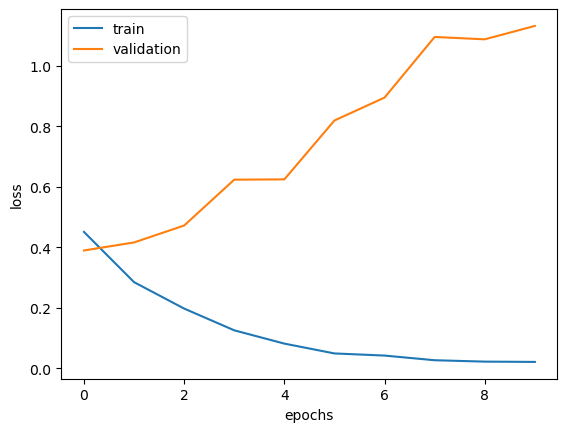

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()